## Projeto Machine Learning III

Autores:
- Ana Carolina Ferreira
- Diego Dio
- Fernando Brancher
- Marília Melo
- Mayara Medeiros

## Apresentação

**Objetivo:**

Criar modelos de classificação para prever se o tomador do empréstimo ficará inadimplente ou não.

Fonte de dados: https://www.kaggle.com/datasets/yasserh/loan-default-dataset

### Processo e técnicas utilizadas

- 1. Leitura e análise exploratória dos dados
    * 1.1. Características do dataset
    * 1.2. Análise exploratória inicial
    * 1.3. Análise dos dados faltantes
- 2. Tratamento dos dados faltantes e pré-processamento
    * 2.1. Remoção de colunas e dados faltantes
    * 2.2. Divisão do dataset
    * 2.3. Corte de outliers
    * 2.4. Undersampling
    * 2.5. Encoding
    * 2.6. Pipeline de pré-processamento
    * 2.7. Visualização das features após tratamento
- 3. Seleção de features e redução de dimensionalidade
    * 3.1. Testes com Lasso, Permutation Importance e RFE
    * 3.2. Redução de dimensionalidade com PCA
- 4. Machine Learning
    * 4.1. Testes com Regressão Logística, Random Forest e XGBoost
    * 4.2. Ajuste de hiperparâmetros com Otimização Bayesiana
    * 4.3. Modelo final com XGBoost
- 5. Explicabilidade do modelo
    * 5.1. Lime
    * 5.2. Shap

*Encontrei esse dicionário no projeto de outra pessoa, não é oficial, mas deve ajudar* (remover antes da apresnetação)

- **ID** = Customer ID of Applicant
- **year** = Year of Application
- **loan limit** = maximum avaliable amount of the loan allowed to be taken
- **Gender** = sex type
- **approv_in_adv** = Is loan pre-approved or not
- **loan_type** = Type of loan
- **loan_purpose** = the reason you want to borrow money
- **Credit_Worthiness** = is how a lender determines that you will default on your debt obligations, or how worthy you are to receive new credit.
- **open_credit** = is a pre-approved loan between a lender and a borrower. It allows the borrower to make repeated withdrawals up to a certain limit.
- **business_or_commercial** = Usage type of the loan amount
- **loan_amount** = The exact loan amount
- **rate_of_interest** = is the amount a lender charges a borrower and is a percentage of the principal—the amount loaned.
- **Interest_rate_spread** = the difference between the interest rate a financial institution pays to depositors and the interest rate it receives from loans
- **Upfront_charges** = Fee paid to a lender by a borrower as consideration for making a new loan
- **term** = the loan's repayment period
- **Neg_ammortization** = refers to a situation when a loan borrower makes a payment less than the standard installment set by the bank.
- **interest_only** = amount of interest only without principles
- **lump_sum_payment** = is an amount of money that is paid in one single payment rather than in installments.
- **property_value** = the present worth of future benefits arising from the ownership of the property
- **construction_type** = Collateral construction type
- **occupancy_type** = classifications refer to categorizing structures based on their usage
- **Secured_by** = Type of Collatoral
- **total_units** = number of unites
- **income** = refers to the amount of money, property, and other transfers of value received over a set period of time
- **credit_type** = type of credit
- **co-applicant_credit_type** = is an additional person involved in the loan application process. Both applicant and co-applicant apply and sign for the loan
- **age** = applicant's age
- **submission_of_application** = Ensure the application is complete or not
- **LTV** = Loan-to-value (LTV) - a measure comparing the amount of your mortgage with the appraised value of the property.
- **Region** = applicant's place
- **Security_Type** = Type of Collatoral
- **status** = Loan status (Approved/Declined)
- **dtir1** = debt-to-income ratio (percentage of income that will be compromised with the loan)

In [2]:
# Manipulação e Visualização dos Dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualização Dados faltantes
# !pip install missingno
import missingno as msno

from sklearn.model_selection import train_test_split, cross_val_score

# Pré-Processamento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer

# Undersampling
from imblearn.under_sampling import RandomUnderSampler

# Feature Selection
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV

# PCA
from sklearn.decomposition import PCA

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métricas
from sklearn.metrics import classification_report

# Tunning hiperparâmetros
from hyperopt import Trials, fmin, hp

# Explicabilidade do modelo
from lime import lime_tabular
import shap

In [3]:
# Rodar
#Rodar uma vez, pra ele mostrar todas as colunas
pd.set_option('display.max_columns', 50)

## 1. Leitura e análise exploratória dos dados

In [9]:
# Rodar
df = pd.read_csv('Loan_Default.csv')
df.head()

ID  year loan_limit             Gender approv_in_adv loan_type   
0  24890  2019         cf  Sex Not Available         nopre     type1  \
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial   
0           p1                l1        nopc                  nob/c  \
1           p1                l1        nopc                    b/c   
2           p1                l1        nopc                  nob/c   
3           p4                l1        nopc                  nob/c   
4           p1                l1        nopc                  nob/c   

   loan_amount  rate_of_interest  Interest_rate_spread  Upfront_charges   
0       116500               NaN                   NaN              NaN  \
1       206500               NaN                   NaN              NaN   
2       406500              4.56                0.2000            595.0   
3       456500              4.25                0.6810              NaN   
4       696500              4.00                0.3042              0.0   

    term Neg_ammortization interest_only lump_sum_payment  property_value   
0  360.0           not_neg       not_int         not_lpsm        118000.0  \
1  360.0           not_neg       not_int             lpsm             NaN   
2  360.0           neg_amm       not_int         not_lpsm        508000.0   
3  360.0           not_neg       not_int         not_lpsm        658000.0   
4  360.0           not_neg       not_int         not_lpsm        758000.0   

  construction_type occupancy_type Secured_by total_units   income   
0                sb             pr       home          1U   1740.0  \
1                sb             pr       home          1U   4980.0   
2                sb             pr       home          1U   9480.0   
3                sb             pr       home          1U  11880.0   
4                sb             pr       home          1U  10440.0   

  credit_type  Credit_Score co-applicant_credit_type    age   
0         EXP           758                      CIB  25-34  \
1        EQUI           552                      EXP  55-64   
2         EXP           834                      CIB  35-44   
3         EXP           587                      CIB  45-54   
4        CRIF           602                      EXP  25-34   

  submission_of_application        LTV Region Security_Type  Status  dtir1  
0                   to_inst  98.728814  south        direct       1   45.0  
1                   to_inst        NaN  North        direct       1    NaN  
2                   to_inst  80.019685  south        direct       0   46.0  
3                  not_inst  69.376900  North        direct       0   42.0  
4                  not_inst  91.886544  North        direct       0   39.0

In [5]:
print(df.shape)
df.info()

(148670, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges 

### 1.1 Características do dataset:
- 148670 linhas
- 34 colunas
    - 1 coluna ID
    - 1 coluna target - Status
    - 21 colunas com dados categóricos
    - 11 colunas com dados numéricos
        - coluna ano com apenas um valor: 2019

### 1.2 Análise Exploratória Inicial

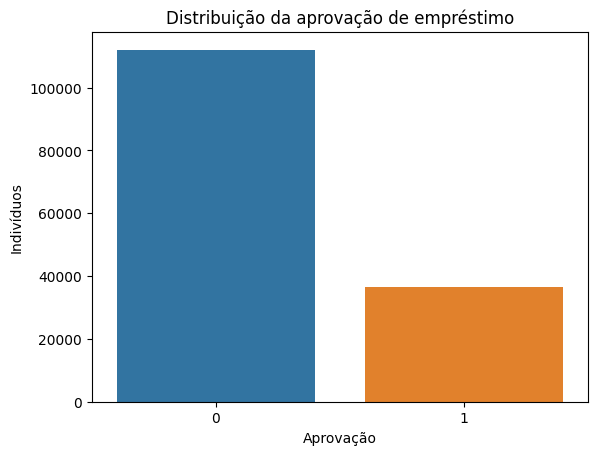

In [22]:
# Análise de balanceamento do target do dataset
sns.countplot(data=df, x='Status')
plt.title('Distribuição da aprovação de empréstimo')
plt.ylabel('Indivíduos')
plt.xlabel('Aprovação')
plt.show()

Nosso target ```Status``` é desbalanceado, podemos pensar em maneira de equilibrar a distribuição. 

Ideias:

- *Undersampling:* remover parte das observações da classe 0 para balancear. Sugestão, algo em torno de 60-40% acho que já seria OK.
- *Oversamplig:* criar dados sintéticos para a classe 1, até um o momento de criar uma distribuição mais balanceada.

Como temos um bom valor na classe 1, acredito que o *undersampling* já nos ajude, para evitar a criação de dados sintéticos.

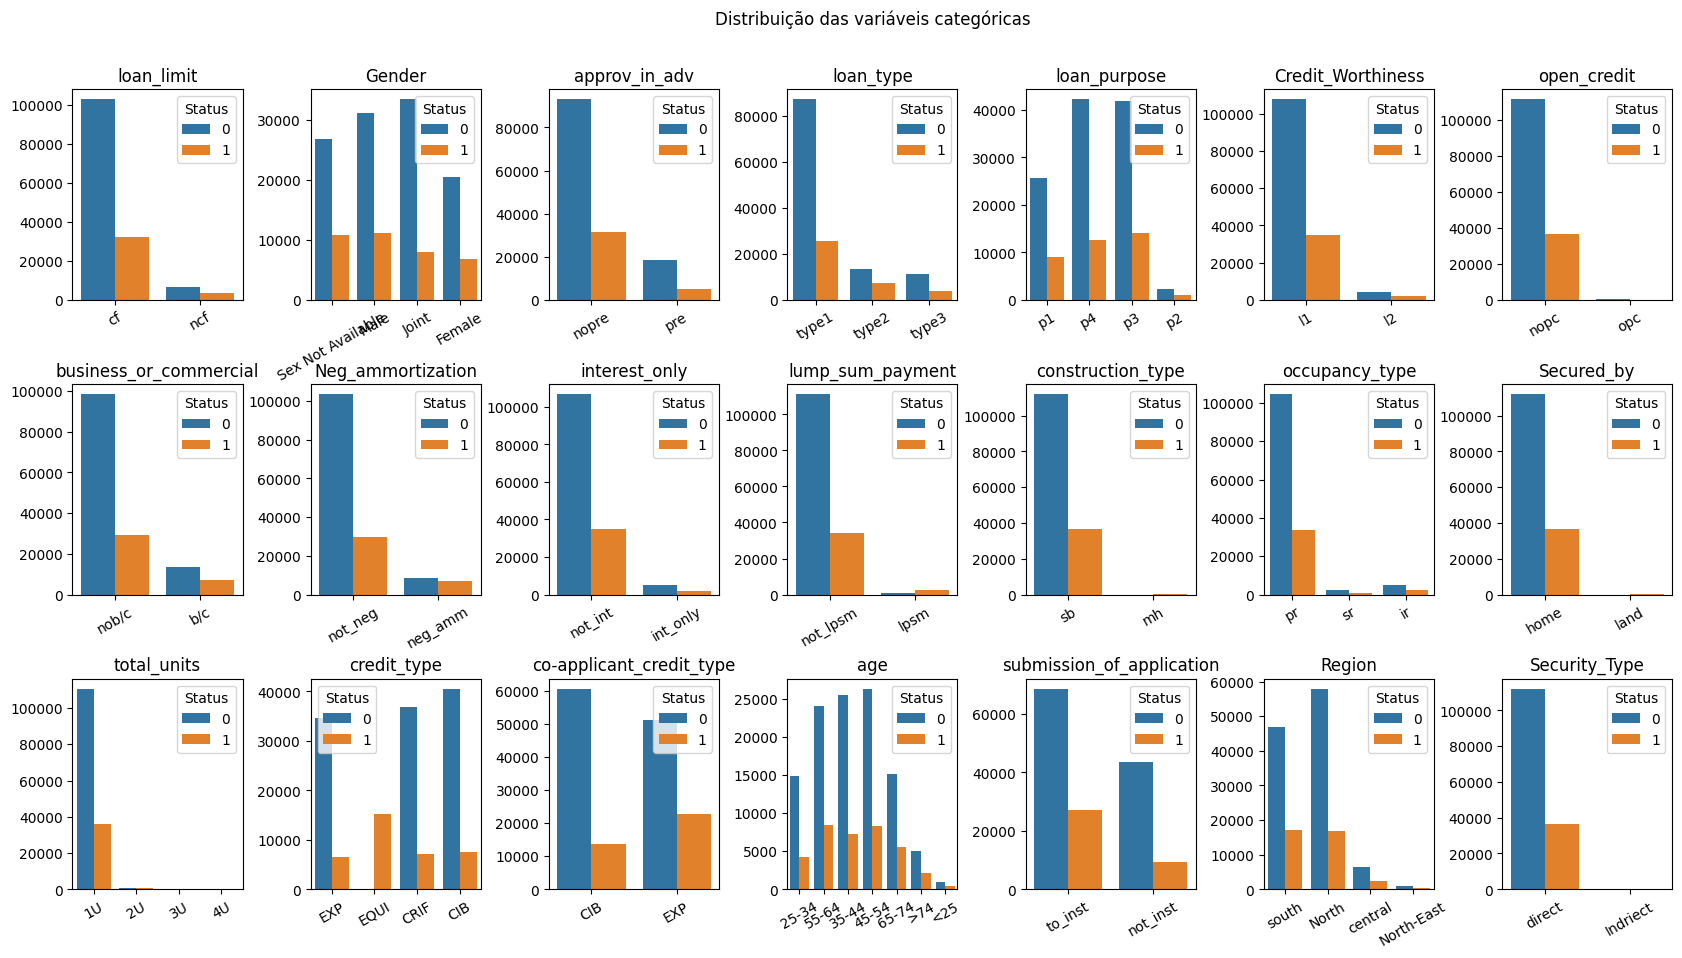

In [23]:
# Distribuição das variáveis categóricas
category_list = ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
                 'Credit_Worthiness', 'open_credit', 'business_or_commercial',
                 'Neg_ammortization', 'interest_only', 'lump_sum_payment',
                 'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
                 'credit_type', 'co-applicant_credit_type', 'age',
                 'submission_of_application', 'Region', 'Security_Type']
count = 1
fig = plt.figure(figsize=(20,10))

for category in category_list:
    fig.add_subplot(3,7, count)
    sns.countplot(data = df,
                  x=category, 
                  hue='Status')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(rotation=30)
    plt.title(category)
    count += 1
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    
plt.suptitle('Distribuição das variáveis categóricas')
plt.show()

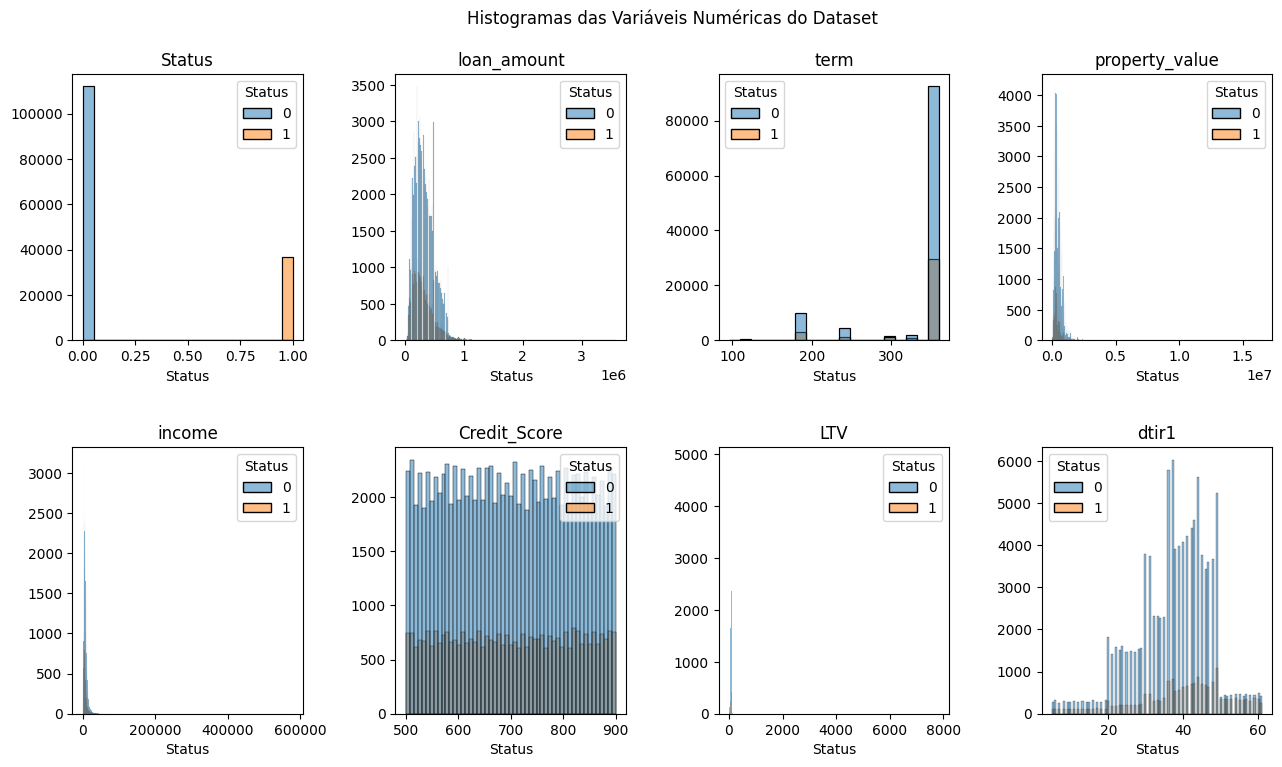

In [5]:
# Histograma das features
numeric_list = ['Status', 'loan_amount', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']

fig= plt.figure(figsize=(15,8))

for number, category in enumerate(numeric_list, start=1):
    ax = fig.add_subplot(2,4,number)
    sns.histplot(data=df, x=category, hue='Status')
    plt.title(category)
    plt.xlabel('Status')
    ax.set_ylabel('')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.suptitle('Histogramas das Variáveis Numéricas do Dataset')
plt.show()

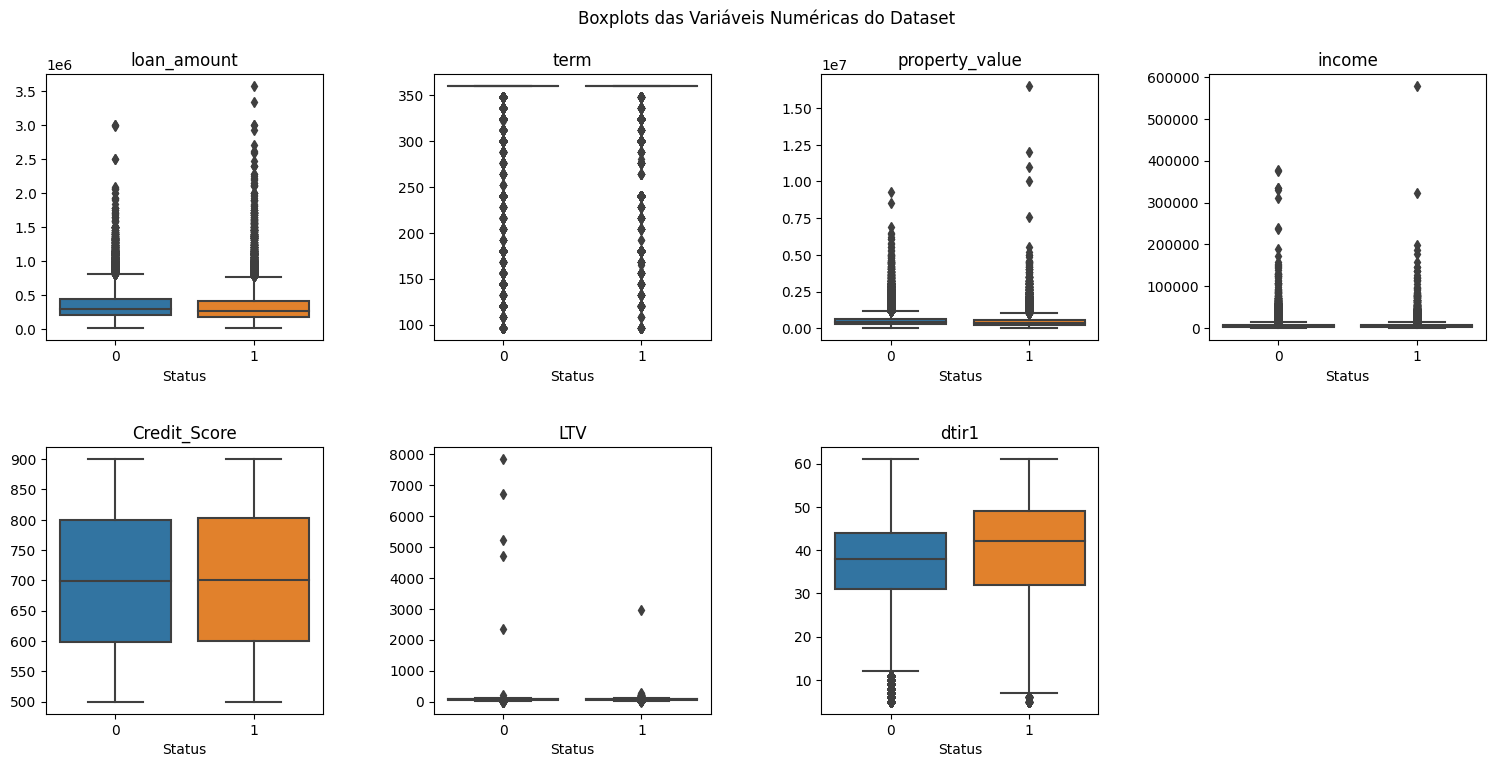

In [7]:
# Boxplot das features
numeric_list = ['loan_amount', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']

fig= plt.figure(figsize=(18,8))

for number, category in enumerate(numeric_list, start=1):
    ax = fig.add_subplot(2,4,number)
    sns.boxplot(data=df, y=category, x='Status')
    plt.title(category)
    plt.xlabel('Status')
    ax.set_ylabel('')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.suptitle('Boxplots das Variáveis Numéricas do Dataset')
plt.show()

Analisando os dados expressos nos boxplots acima, além do fato de várias features apresentarem vários outliers, nenhuma distribuição se destaca.

Apenas ```dtir1``` tem uma leve disparidade no intervalo interquatil.

### 1.3 Análise dos dados faltantes

In [4]:
df.duplicated().sum()

0

In [4]:
df.isnull().sum().sort_values(ascending=False).head(15)

Upfront_charges              39642
Interest_rate_spread         36639
rate_of_interest             36439
dtir1                        24121
LTV                          15098
property_value               15098
income                        9150
loan_limit                    3344
approv_in_adv                  908
submission_of_application      200
age                            200
loan_purpose                   134
Neg_ammortization              121
term                            41
Region                           0
dtype: int64

#### Visualização de dados faltantes

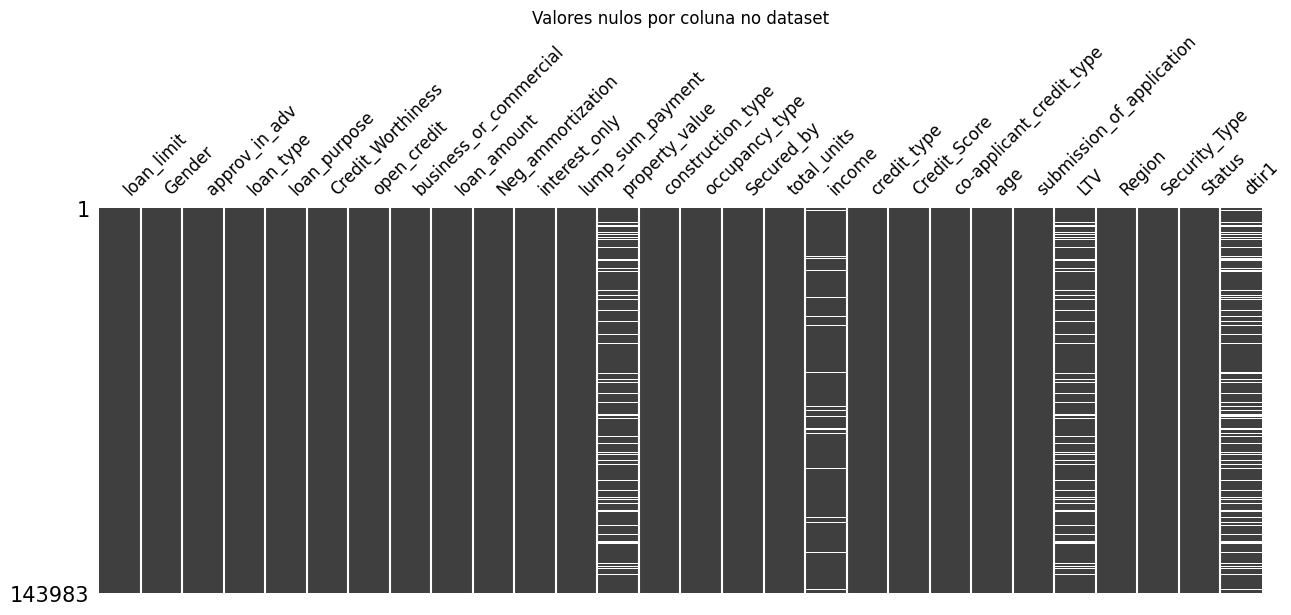

In [8]:
# Instalar pacote missingno
# pip install missingno

msno.matrix(df, figsize=(15, 5), fontsize=12, labels=True, sparkline=False)
plt.title('Valores nulos por coluna no dataset')
plt.show()

#### Comparando empréstimos aprovados e reprovados

In [9]:
# Valores nulo quando Status = 0 ou = 1
df_status0 = df[df['Status'] == 0].copy()
df_status1 = df[df['Status'] == 1].copy()

indices_faltantes = list(df.isnull().sum().sort_values(ascending=False)[:14].index) #filtra apenas os que tem dados faltantes

indices = df_status1.isna().sum().index
valores_status0 = np.array(df_status0.isna().sum())
valores_status1 = np.array(df_status1.isna().sum())
df_valores_nulos = pd.DataFrame({'coluna': indices, 'Status 0': valores_status0, 'Status 1': valores_status1})
df_valores_nulos.loc[df_valores_nulos['coluna'].isin(indices_faltantes)]

coluna  Status 0  Status 1
2                  loan_limit      2463       881
4               approv_in_adv       667       241
6                loan_purpose        99        35
11           rate_of_interest         0     36439
12       Interest_rate_spread         0     36639
13            Upfront_charges      3156     36486
14                       term        26        15
15          Neg_ammortization        89        32
18             property_value         2     15096
23                     income      7911      1239
27                        age         0       200
28  submission_of_application         0       200
29                        LTV         2     15096
33                      dtir1      7811     16310

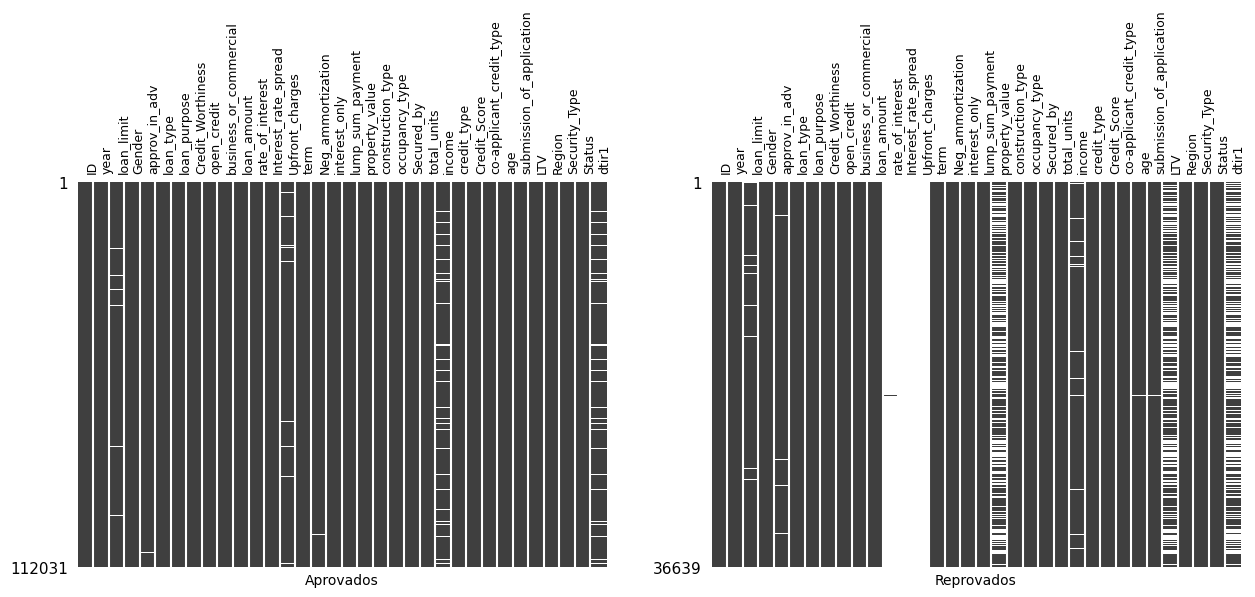

In [9]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,2,1)
msno.matrix(df_status0, fontsize=9, labels=True, sparkline=False, ax=ax1)
plt.xlabel('Aprovados')
plt.xticks(rotation=90)

ax2 = fig.add_subplot(1,2,2)
msno.matrix(df_status1, fontsize=9, labels=True, sparkline=False, ax=ax2)
plt.xlabel('Reprovados')
plt.xticks(rotation=90)

plt.show()

In [29]:
def porcentagem_nulos(df):
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing = {}
    nulls_list = []
    pct_list = []

    for col in missing_columns:
        nulls = df[col].isnull().sum()
        pct = (nulls/df.shape[0]) * 100
        
        nulls_list.append(nulls)
        pct_list.append(str(round(pct, 2)) + '%')
        
        missing['Nulos'] = nulls_list
        missing['Porcentagem'] = pct_list

    return pd.DataFrame(missing, index=missing_columns)


In [32]:
print('Valores nulos para cada coluna e porcentagem para dataset total, somente "Status = 0" e somente "Status = 1"')
pd.concat([porcentagem_nulos(df), porcentagem_nulos(df_status0), porcentagem_nulos(df_status1)], axis=1)

Valores nulos para cada coluna e porcentagem para dataset total, somente "Status = 0" e somente "Status = 1"


Nulos Porcentagem   Nulos Porcentagem  Nulos   
loan_limit                  3344       2.25%  2463.0        2.2%    881  \
approv_in_adv                908       0.61%   667.0        0.6%    241   
loan_purpose                 134       0.09%    99.0       0.09%     35   
rate_of_interest           36439      24.51%     NaN         NaN  36439   
Interest_rate_spread       36639      24.64%     NaN         NaN  36639   
Upfront_charges            39642      26.66%  3156.0       2.82%  36486   
term                          41       0.03%    26.0       0.02%     15   
Neg_ammortization            121       0.08%    89.0       0.08%     32   
property_value             15098      10.16%     2.0        0.0%  15096   
income                      9150       6.15%  7911.0       7.06%   1239   
age                          200       0.13%     NaN         NaN    200   
submission_of_application    200       0.13%     NaN         NaN    200   
LTV                        15098      10.16%     2.0        0.0%  15096   
dtir1                      24121      16.22%  7811.0       6.97%  16310   

                          Porcentagem  
loan_limit                       2.4%  
approv_in_adv                   0.66%  
loan_purpose                     0.1%  
rate_of_interest               99.45%  
Interest_rate_spread           100.0%  
Upfront_charges                99.58%  
term                            0.04%  
Neg_ammortization               0.09%  
property_value                  41.2%  
income                          3.38%  
age                             0.55%  
submission_of_application       0.55%  
LTV                             41.2%  
dtir1                          44.52%

Analisando as informações acima, observamos que:
- Em ```rate_of_interest```, ```Interest_rate_spread```, ```Upfront_charges``` os dados nulos configuram >99% da coluna para **Status 1** (Reprovados)
- Em , ```property_value```, ```LTV``` e ```dtir1``` os nulos configuram ~40% da coluna para **Status 1** (Reprovados)
- As demais colunas com dados faltantes apresentam distribuições similares entre **Status 0** e **Status 1**

Podemos observar que os valores faltantes nas colunas 'rate_of_interest', 'interest_rate_spread' e 'Upfront_charges' estão fortemente ligadas ao Status de aprovação do empréstimo. Portanto, avaliamos possivelmente se tratarem de valores relacionados a processos pós-aprovação e decidimos por excluir essas colunas.

## 2. Tratamento de dados faltantes e pré-processamento

### 2.1 Remoção de colunas e dados faltantes

In [10]:
# Rodar
# Drop de colunas de ID, não informativas ou colunas que configuram 99% de dados faltantes para Status 1
df.drop(columns=['ID', 'year','rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term'], inplace=True)

# Drop de dados faltantes em colunas com menos de 5% dos dados totais e similarmente distribuidos entre Status 0 e Status 1
df.dropna(subset=['loan_limit', 'approv_in_adv', 'loan_purpose', 'Neg_ammortization', 'age', 'submission_of_application'], inplace=True) 

df.shape

(143983, 28)

Análise da quantidade de dados:

|                      | **Linhas** | **Colunas** |
|----------------------|:----------:|:-----------:|
| Antes do tratamento  |   148.670  |      34     |
| Depois do tratamento |   143.942  |      29     |

Apesar de vários tratamentos e alguns drops, nesse tratamento foram removidos cerca de 3% dos dados, a maioria nulos.

In [11]:
# Dataset sem dados nulos (rever implementação do KNN para remover esses dados abaixo )
df.isnull().sum().sort_values(ascending=False).head(5)

dtir1             23317
LTV               14609
property_value    14609
income             8834
Secured_by            0
dtype: int64

In [6]:
# Rodar
# Subsample dos dados com status = 0

# separa novamente de acordo com os status
# df_status0s = df[df['Status'] == 0].copy()
# df_status1s = df[df['Status'] == 1].copy()

# df_filter_status0 = df_status0s.sample(frac=0.35)
# df_sample = pd.concat([df_filter_status0, df_status1s])
# df_sample['Status'].value_counts()

Status
0    38040
1    35255
Name: count, dtype: int64

### 2.2 Divisão do dataset

In [13]:
# Rodar
treino, teste = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Status'])

In [14]:
print(treino.shape)
treino.head()

(115186, 28)


loan_limit  Gender approv_in_adv loan_type loan_purpose   
118067         cf    Male         nopre     type1           p1  \
144202        ncf  Female         nopre     type1           p3   
142050         cf   Joint         nopre     type1           p4   
142169         cf   Joint         nopre     type1           p3   
8570           cf   Joint           pre     type1           p2   

       Credit_Worthiness open_credit business_or_commercial  loan_amount   
118067                l1        nopc                  nob/c       136500  \
144202                l1        nopc                  nob/c       416500   
142050                l1        nopc                  nob/c       396500   
142169                l1        nopc                  nob/c       286500   
8570                  l1        nopc                  nob/c       456500   

       Neg_ammortization interest_only lump_sum_payment  property_value   
118067           not_neg       not_int         not_lpsm        178000.0  \
144202           not_neg       not_int         not_lpsm        708000.0   
142050           not_neg       not_int         not_lpsm        578000.0   
142169           not_neg       not_int         not_lpsm        418000.0   
8570             not_neg       not_int         not_lpsm       1228000.0   

       construction_type occupancy_type Secured_by total_units   income   
118067                sb             pr       home          1U   2700.0  \
144202                sb             pr       home          1U   6780.0   
142050                sb             pr       home          1U  10920.0   
142169                sb             pr       home          1U   3600.0   
8570                  sb             ir       home          1U  10260.0   

       credit_type  Credit_Score co-applicant_credit_type    age   
118067        CRIF           837                      CIB  65-74  \
144202        CRIF           623                      CIB  45-54   
142050        CRIF           790                      EXP  45-54   
142169         EXP           822                      EXP  55-64   
8570           CIB           626                      EXP  45-54   

       submission_of_application        LTV Region Security_Type  Status   
118067                   to_inst  76.685393  North        direct       1  \
144202                  not_inst  58.827684  North        direct       0   
142050                  not_inst  68.598616  south        direct       0   
142169                   to_inst  68.540670  North        direct       0   
8570                    not_inst  37.174267  south        direct       0   

        dtir1  
118067   49.0  
144202   28.0  
142050    7.0  
142169   30.0  
8570     49.0

### 2.3 Corte de outliers

In [15]:
# Rodar
# Corte dos outliers ['loan_amount', 'property_value', 'income', 'LTV', 'dtir1']

outliers_list = ['loan_amount', 'property_value', 'income', 'LTV', 'dtir1']

for feat in outliers_list:
    median = treino[feat].median()
    std = treino[feat].std()
    lower, upper = median - (3*std), median + (3*std)
    treino_trimmed = treino[(treino[feat] > lower) & (treino[feat] < upper)]

print(treino_trimmed.shape)
treino_trimmed['Status'].value_counts()


(95624, 28)


Status
0    80137
1    15487
Name: count, dtype: int64

In [16]:
X_train = treino_trimmed.drop(columns='Status')
y_train = treino_trimmed['Status']

X_test = teste.drop(columns='Status')
y_test = teste['Status']

### 2.4 Undersampling

In [17]:
# Undersampling
# Crie um objeto RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy=1, random_state=42)

# Realize o undersampling no conjunto de treinamento
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [18]:
print(y_train_resampled.shape)
y_train_resampled.value_counts()

(30974,)


Status
0    15487
1    15487
Name: count, dtype: int64

### 2.5 Encoding dos dados

In [19]:
# Rodar
# Separando as features de acordo com os tratamentos

# Features categóricas nominais: 
features_cat = list(df.select_dtypes(exclude=np.number).columns)
features_cat.remove('total_units')
features_cat.remove('age')

# Define a ordem para o OrdinalEncoder
units_order = ['1U', '2U', '3U', '4U']
age_order = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74']
# Features categóricas ordinais: 
features_ord = ['total_units','age']

# Features numéricas:
features_num = list(df.select_dtypes(include=np.number).columns)
features_num.remove('Status')

### 2.6 Pipeline de pré-processamento dos dados

In [20]:
# Rodar
# Aplicando as transformações

pipe_feat_num = Pipeline([
    ('input_num', KNNImputer(n_neighbors = 2)), # Opção 2: ('input_num', SimpleImputer(strategy = "mean")) (troquei pra knnimputer)
    ('pw_transf', PowerTransformer()), # Considerar PowerTransformer() (sklearn.preprocessing) para transformar os dados numa escala Log e corrigir a skwedness.    
])

# Aplica cada transformação nas respectivas colunas
pre_processamento = ColumnTransformer([
        ('transf_cat', OneHotEncoder(drop='first', sparse_output=False), features_cat),
        ('transf_ord', OrdinalEncoder(categories=[units_order, age_order]), features_ord),
        ('_pipe_num_', pipe_feat_num, features_num)
], remainder='passthrough')

# Para que o output seja um dataframe do pandas
pre_processamento.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('transf_cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['loan_limit', 'Gender', 'approv_in_adv',
                                  'loan_type', 'loan_purpose',
                                  'Credit_Worthiness', 'open_credit',
                                  'business_or_commercial', 'Neg_ammortization',
                                  'interest_only', 'lump_sum_payment',
                                  'construction_type', 'occupancy_type',
                                  'Secured_by', 'c...
                                  'submission_of_application', 'Region',
                                  'Security_Type']),
                                ('transf_ord',
                                 OrdinalEncoder(categories=[['1U', '2U', '3U',
                                                             '4U'],
                                                            ['<25', '25-34',
                                                             '35-44', '45-54',
                                                             '55-64', '65-74',
                                                             '>74']]),
                                 ['total_units', 'age']),
                                ('_pipe_num_',
                                 Pipeline(steps=[('input_num',
                                                  KNNImputer(n_neighbors=2)),
                                                 ('pw_transf',
                                                  PowerTransformer())]),
                                 ['loan_amount', 'property_value', 'income',
                                  'Credit_Score', 'LTV', 'dtir1'])])

**Um pouco sobre o KNN Imputer**

Como ele funciona:

<img src='https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fe517b2b2-aa4d-4ad2-9f71-ad068c4db993_3115x1744.png' width='500'>

Por que usá-lo?

<img src='https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F0d8bb4da-0c62-4492-8dfd-b30f5530d8ca_2973x3153.jpeg' width='450'>

Para saber mais: [Clique aqui](https://www.blog.dailydoseofds.com/p/the-most-overlooked-problem-with-768?utm_source=post-email-title&publication_id=1119889&post_id=135561523&isFreemail=true&utm_medium=email)

#### Transformando dados de treino

In [21]:
# Rodar
# Column Transform: dados de treino
X_train_transformed = pre_processamento.fit_transform(X_train_resampled)

new_columns = list(X_train_transformed.columns)
for column in range(len(new_columns)):
    new_columns[column] = new_columns[column][12:]

X_train_transformed.columns = new_columns

X_train_transformed.head(2)

loan_limit_ncf  Gender_Joint  Gender_Male  Gender_Sex Not Available   
3844              0.0           0.0          0.0                       1.0  \
69332             0.0           0.0          0.0                       1.0   

       approv_in_adv_pre  loan_type_type2  loan_type_type3  loan_purpose_p2   
3844                 1.0              0.0              0.0              0.0  \
69332                0.0              0.0              0.0              0.0   

       loan_purpose_p3  loan_purpose_p4  Credit_Worthiness_l2   
3844               0.0              0.0                   0.0  \
69332              1.0              0.0                   0.0   

       open_credit_opc  business_or_commercial_nob/c   
3844               0.0                           1.0  \
69332              0.0                           1.0   

       Neg_ammortization_not_neg  interest_only_not_int   
3844                         1.0                    1.0  \
69332                        0.0                    1.0   

       lump_sum_payment_not_lpsm  construction_type_sb  occupancy_type_pr   
3844                         1.0                   1.0                1.0  \
69332                        1.0                   1.0                1.0   

       occupancy_type_sr  Secured_by_land  credit_type_CRIF  credit_type_EQUI   
3844                 0.0              0.0               0.0               0.0  \
69332                0.0              0.0               0.0               0.0   

       credit_type_EXP  co-applicant_credit_type_EXP   
3844               0.0                           1.0  \
69332              1.0                           1.0   

       submission_of_application_to_inst  Region_North-East  Region_central   
3844                                 1.0                0.0             0.0  \
69332                                1.0                0.0             0.0   

       Region_south  Security_Type_direct  total_units  age  loan_amount   
3844            1.0                   1.0          0.0  2.0     0.768572  \
69332           1.0                   1.0          0.0  2.0     0.551392   

       property_value    income  Credit_Score       LTV     dtir1  
3844         0.672913  0.399909     -1.675878 -0.131942 -0.330217  
69332        0.672913  0.412144      0.744530 -0.549068 -0.420811

#### Transformando dados de teste

In [22]:
# Rodar
# Column Transform: dados de teste
X_test_transformed = pre_processamento.transform(X_test)

new_columns = list(X_test_transformed.columns)
for column in range(len(new_columns)):
    new_columns[column] = new_columns[column][12:]

X_test_transformed.columns = new_columns

X_test_transformed.head(2)

loan_limit_ncf  Gender_Joint  Gender_Male  Gender_Sex Not Available   
104860             0.0           0.0          0.0                       0.0  \
67657              0.0           0.0          1.0                       0.0   

        approv_in_adv_pre  loan_type_type2  loan_type_type3  loan_purpose_p2   
104860                0.0              1.0              0.0              0.0  \
67657                 0.0              0.0              0.0              1.0   

        loan_purpose_p3  loan_purpose_p4  Credit_Worthiness_l2   
104860              0.0              1.0                   0.0  \
67657               0.0              0.0                   0.0   

        open_credit_opc  business_or_commercial_nob/c   
104860              0.0                           0.0  \
67657               0.0                           1.0   

        Neg_ammortization_not_neg  interest_only_not_int   
104860                        1.0                    0.0  \
67657                         1.0                    1.0   

        lump_sum_payment_not_lpsm  construction_type_sb  occupancy_type_pr   
104860                        1.0                   1.0                1.0  \
67657                         1.0                   1.0                0.0   

        occupancy_type_sr  Secured_by_land  credit_type_CRIF   
104860                0.0              0.0               0.0  \
67657                 0.0              0.0               0.0   

        credit_type_EQUI  credit_type_EXP  co-applicant_credit_type_EXP   
104860               0.0              0.0                           0.0  \
67657                0.0              0.0                           0.0   

        submission_of_application_to_inst  Region_North-East  Region_central   
104860                                0.0                0.0             0.0  \
67657                                 0.0                0.0             0.0   

        Region_south  Security_Type_direct  total_units  age  loan_amount   
104860           1.0                   1.0          0.0  2.0     0.889128  \
67657            1.0                   1.0          0.0  2.0    -0.148605   

        property_value    income  Credit_Score      LTV     dtir1  
104860        0.430567  0.604709      0.569020  0.86193  0.839034  
67657        -0.171848  0.843258      0.794438 -0.03203 -0.330217

In [23]:
X_train_transformed.describe()

loan_limit_ncf  Gender_Joint   Gender_Male  Gender_Sex Not Available   
count    30974.000000  30974.000000  30974.000000              30974.000000  \
mean         0.077969      0.248854      0.293730                  0.267967   
std          0.268127      0.432356      0.455477                  0.442907   
min          0.000000      0.000000      0.000000                  0.000000   
25%          0.000000      0.000000      0.000000                  0.000000   
50%          0.000000      0.000000      0.000000                  0.000000   
75%          0.000000      0.000000      1.000000                  1.000000   
max          1.000000      1.000000      1.000000                  1.000000   

       approv_in_adv_pre  loan_type_type2  loan_type_type3  loan_purpose_p2   
count       30974.000000     30974.000000     30974.000000     30974.000000  \
mean            0.151385         0.155711         0.063731         0.027249   
std             0.358430         0.362587         0.244277         0.162810   
min             0.000000         0.000000         0.000000         0.000000   
25%             0.000000         0.000000         0.000000         0.000000   
50%             0.000000         0.000000         0.000000         0.000000   
75%             0.000000         0.000000         0.000000         0.000000   
max             1.000000         1.000000         1.000000         1.000000   

       loan_purpose_p3  loan_purpose_p4  Credit_Worthiness_l2   
count     30974.000000     30974.000000          30974.000000  \
mean          0.420030         0.322722              0.049816   
std           0.493571         0.467525              0.217568   
min           0.000000         0.000000              0.000000   
25%           0.000000         0.000000              0.000000   
50%           0.000000         0.000000              0.000000   
75%           1.000000         1.000000              0.000000   
max           1.000000         1.000000              1.000000   

       open_credit_opc  business_or_commercial_nob/c   
count     30974.000000                  30974.000000  \
mean          0.003422                      0.844289   
std           0.058401                      0.362587   
min           0.000000                      0.000000   
25%           0.000000                      1.000000   
50%           0.000000                      1.000000   
75%           0.000000                      1.000000   
max           1.000000                      1.000000   

       Neg_ammortization_not_neg  interest_only_not_int   
count               30974.000000           30974.000000  \
mean                    0.864661               0.952541   
std                     0.342091               0.212622   
min                     0.000000               0.000000   
25%                     1.000000               1.000000   
50%                     1.000000               1.000000   
75%                     1.000000               1.000000   
max                     1.000000               1.000000   

       lump_sum_payment_not_lpsm  construction_type_sb  occupancy_type_pr   
count               30974.000000          30974.000000        30974.00000  \
mean                    0.961096              0.999257            0.91777   
std                     0.193368              0.027240            0.27472   
min                     0.000000              0.000000            0.00000   
25%                     1.000000              1.000000            1.00000   
50%                     1.000000              1.000000            1.00000   
75%                     1.000000              1.000000            1.00000   
max                     1.000000              1.000000            1.00000   

       occupancy_type_sr  Secured_by_land  credit_type_CRIF  credit_type_EQUI   
count       30974.000000     30974.000000      30974.000000      30974.000000  \
mean            0.022793         0.000743          0.337670          0.000032   
std             0.14924

In [24]:
#Fazer a análise nos dados de treino
treino = pd.concat([X_train_transformed, y_train_resampled], axis=1)

print(treino.shape)

(30974, 38)


### 2.7 Visualização das features numéricas após transformação

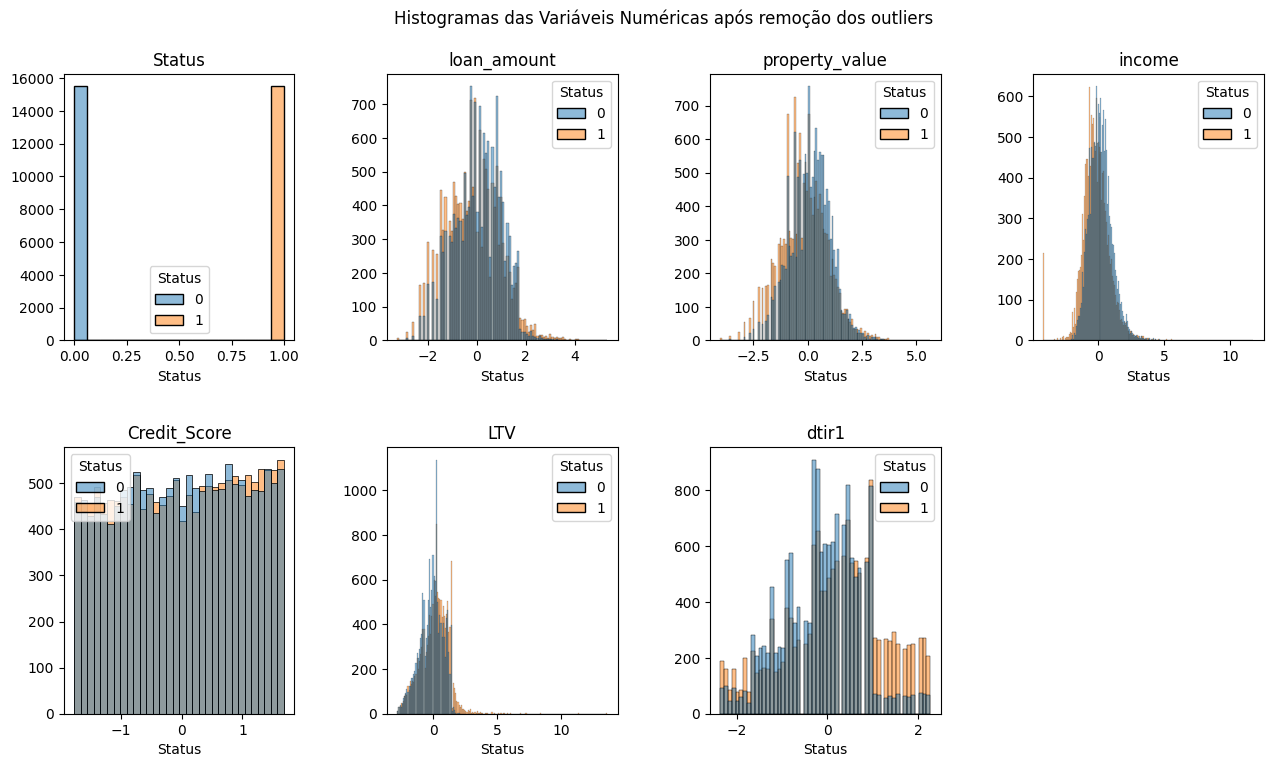

In [25]:
# Histograma das features
numeric_list = ['Status', 'loan_amount', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']

fig= plt.figure(figsize=(15,8))

for number, category in enumerate(numeric_list, start=1):
    ax = fig.add_subplot(2,4,number)
    sns.histplot(data=treino, x=category, hue='Status')
    plt.title(category)
    plt.xlabel('Status')
    ax.set_ylabel('')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.suptitle('Histogramas das Variáveis Numéricas após remoção dos outliers')
plt.show()

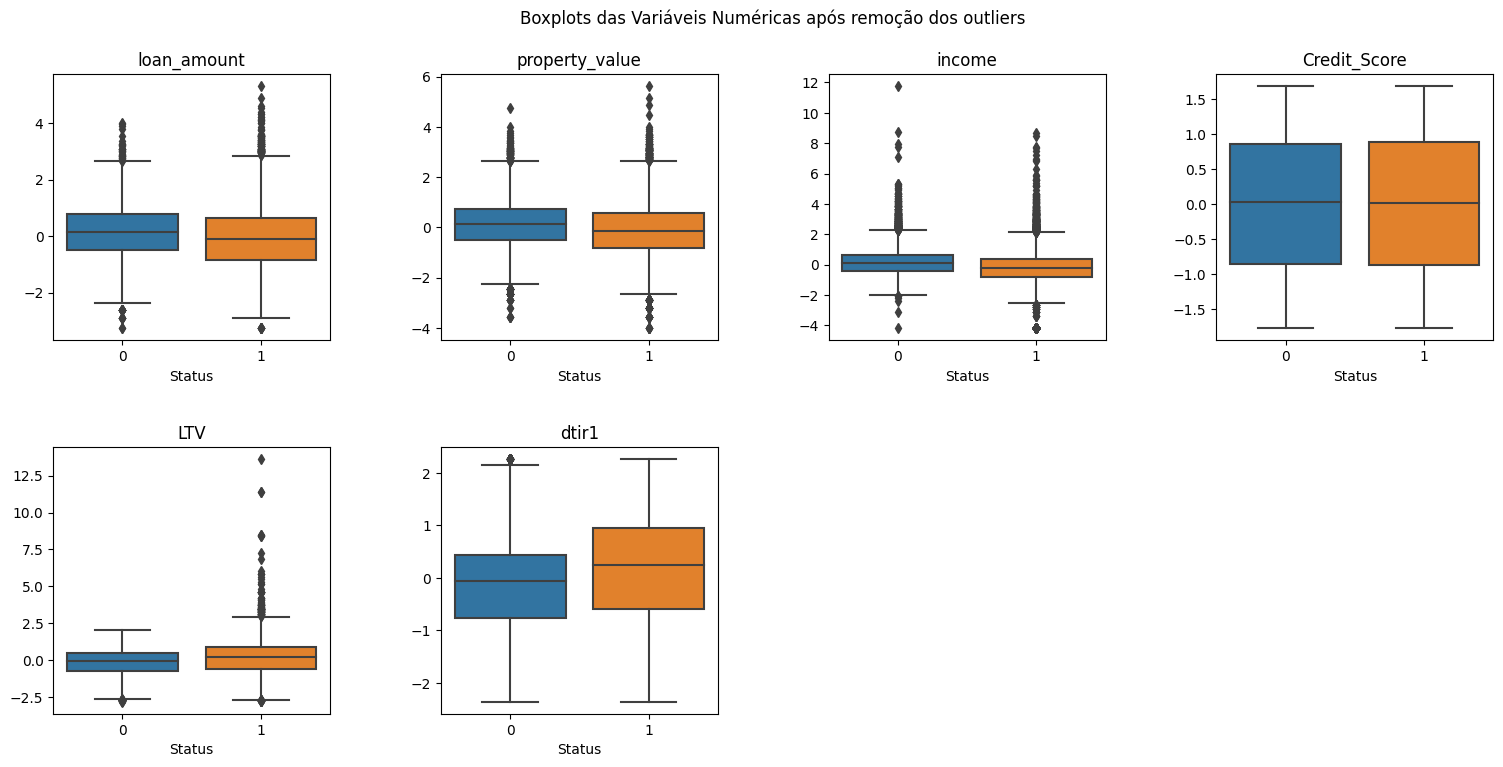

In [26]:
# Boxplot das features
numeric_list = ['loan_amount', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']

fig= plt.figure(figsize=(18,8))

for number, category in enumerate(numeric_list, start=1):
    ax = fig.add_subplot(2,4,number)
    sns.boxplot(data=treino, y=category, x='Status')
    plt.title(category)
    plt.xlabel('Status')
    ax.set_ylabel('')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.suptitle('Boxplots das Variáveis Numéricas após remoção dos outliers')
plt.show()

In [ ]:
# Rodar apenas no final de todas as análises
sns.pairplot(data=treino, hue='Status')

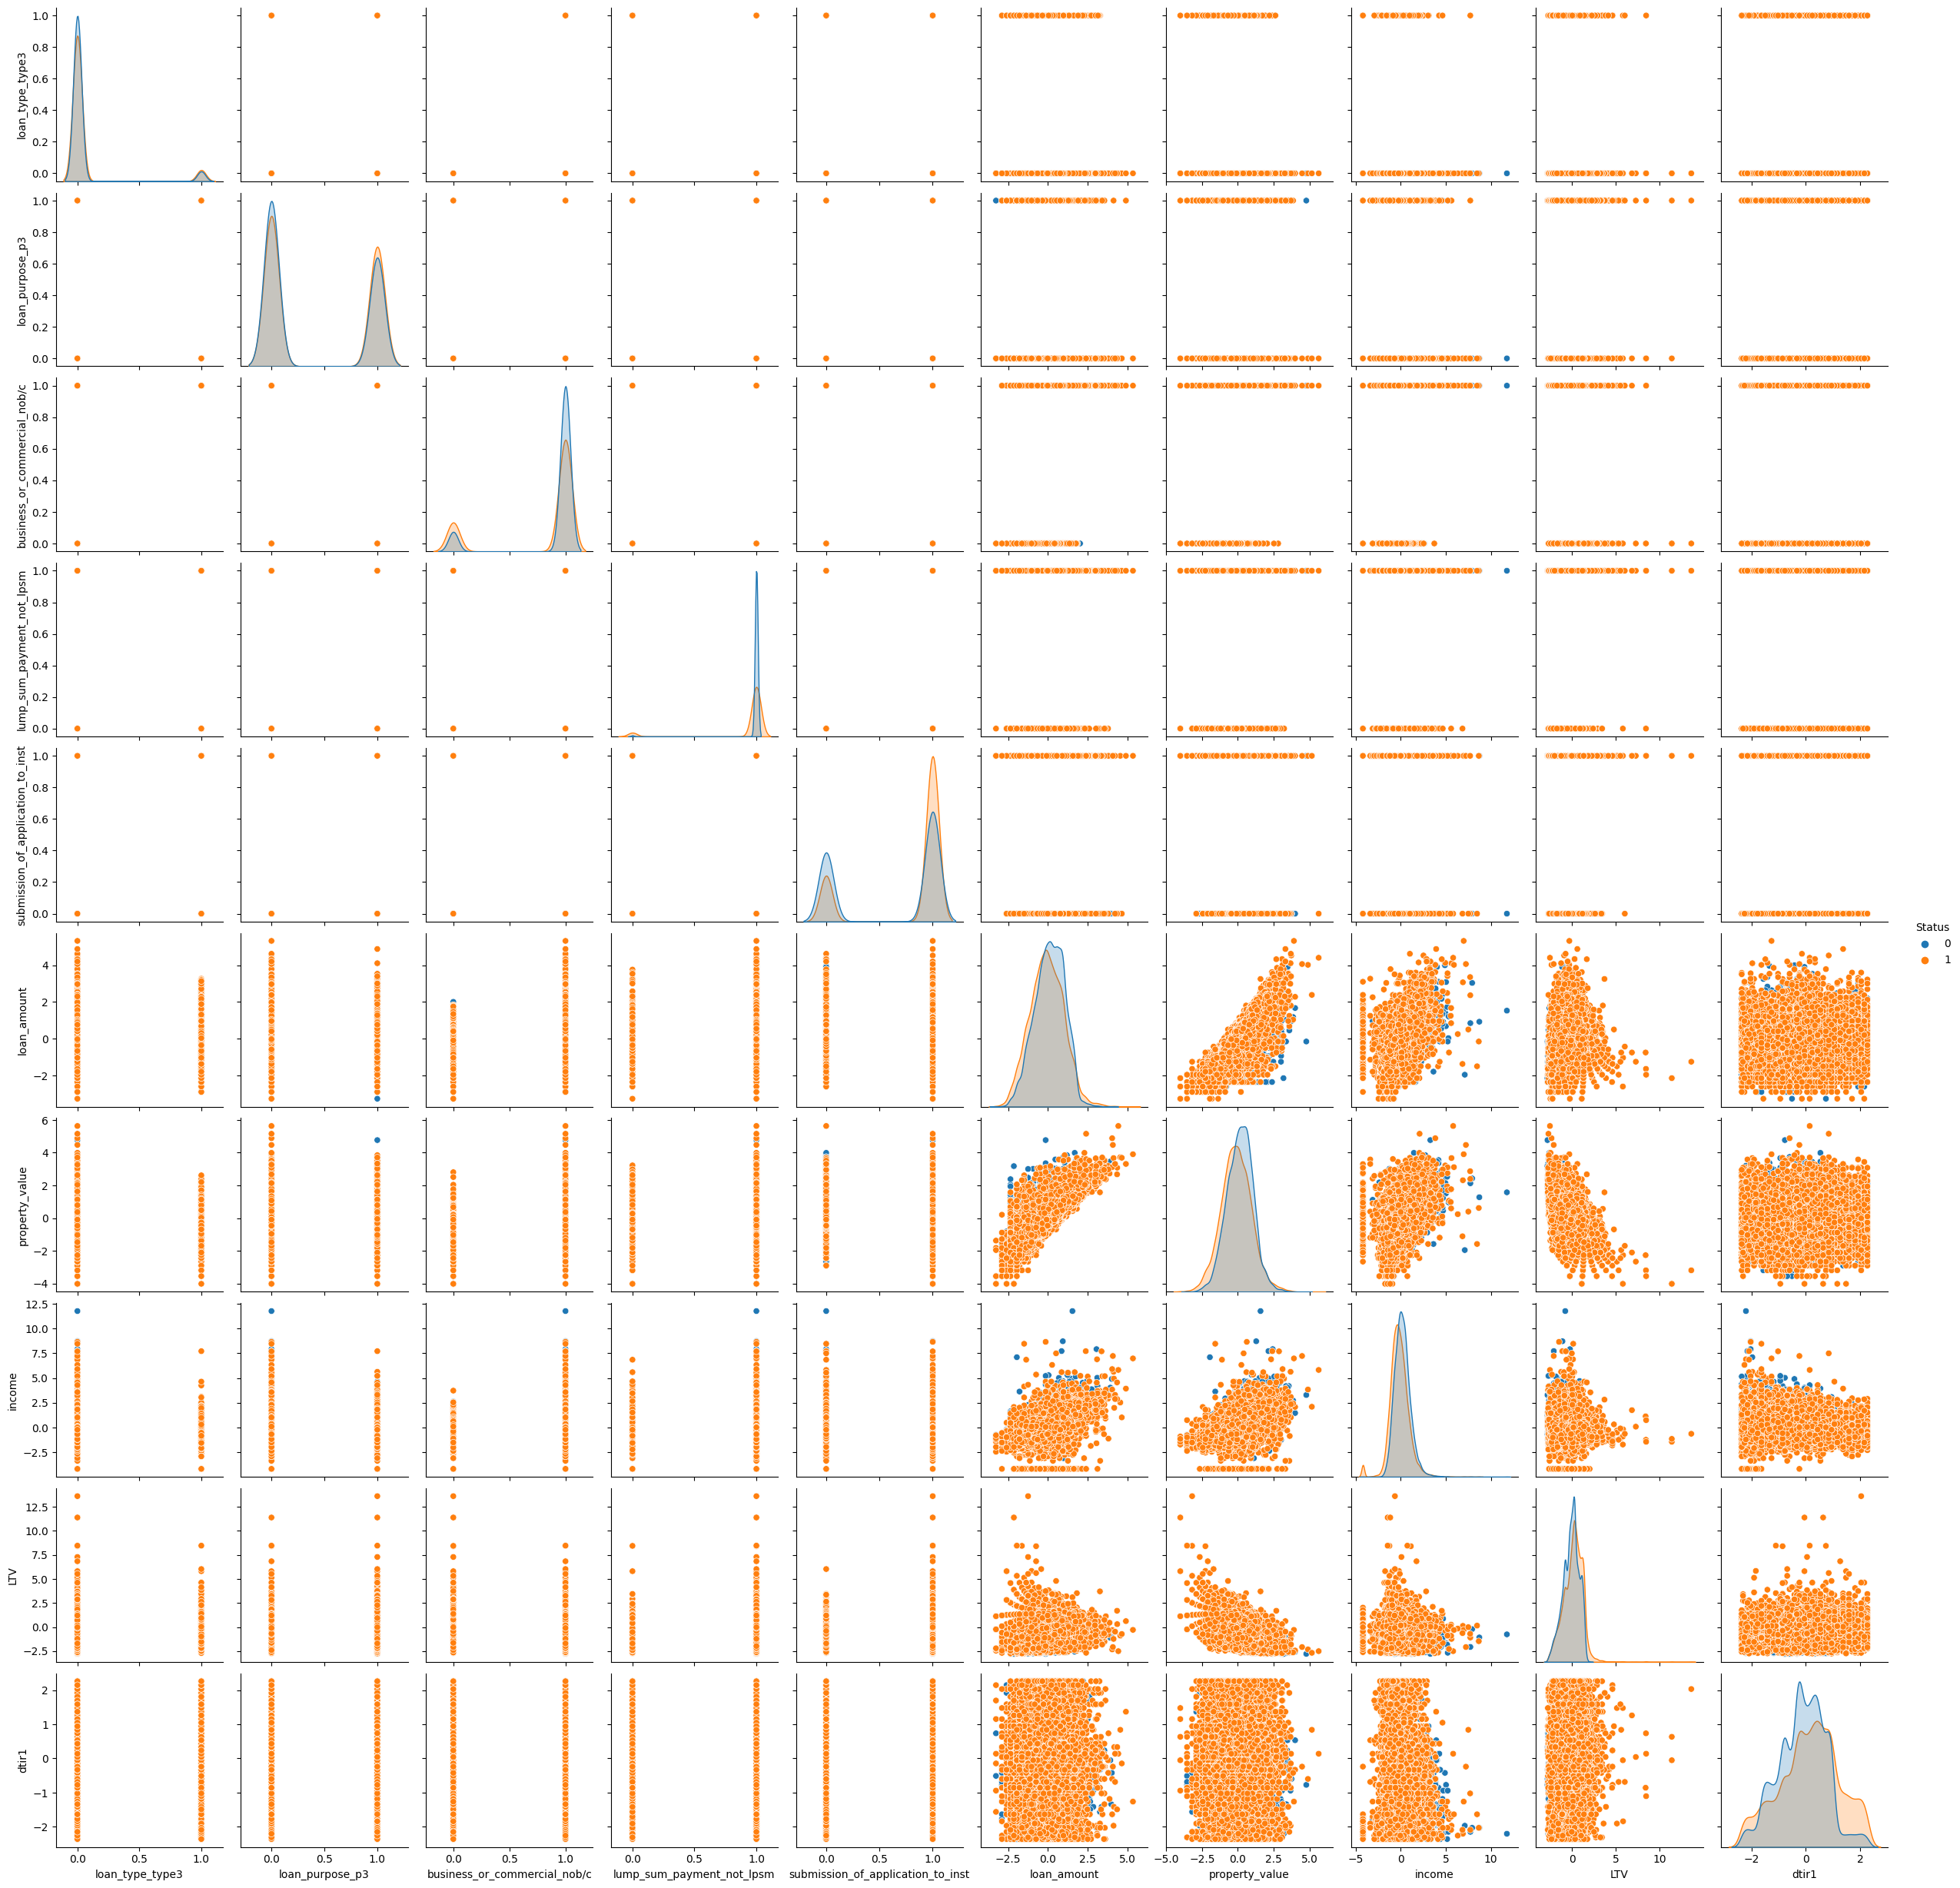

In [89]:
# Usando o X_train apenas com as features selecionadas, rodar ao final do processo.
treino = pd.concat([X_train_ftselec, y_train_resampled], axis=1)
sns.pairplot(data=treino, hue='Status')

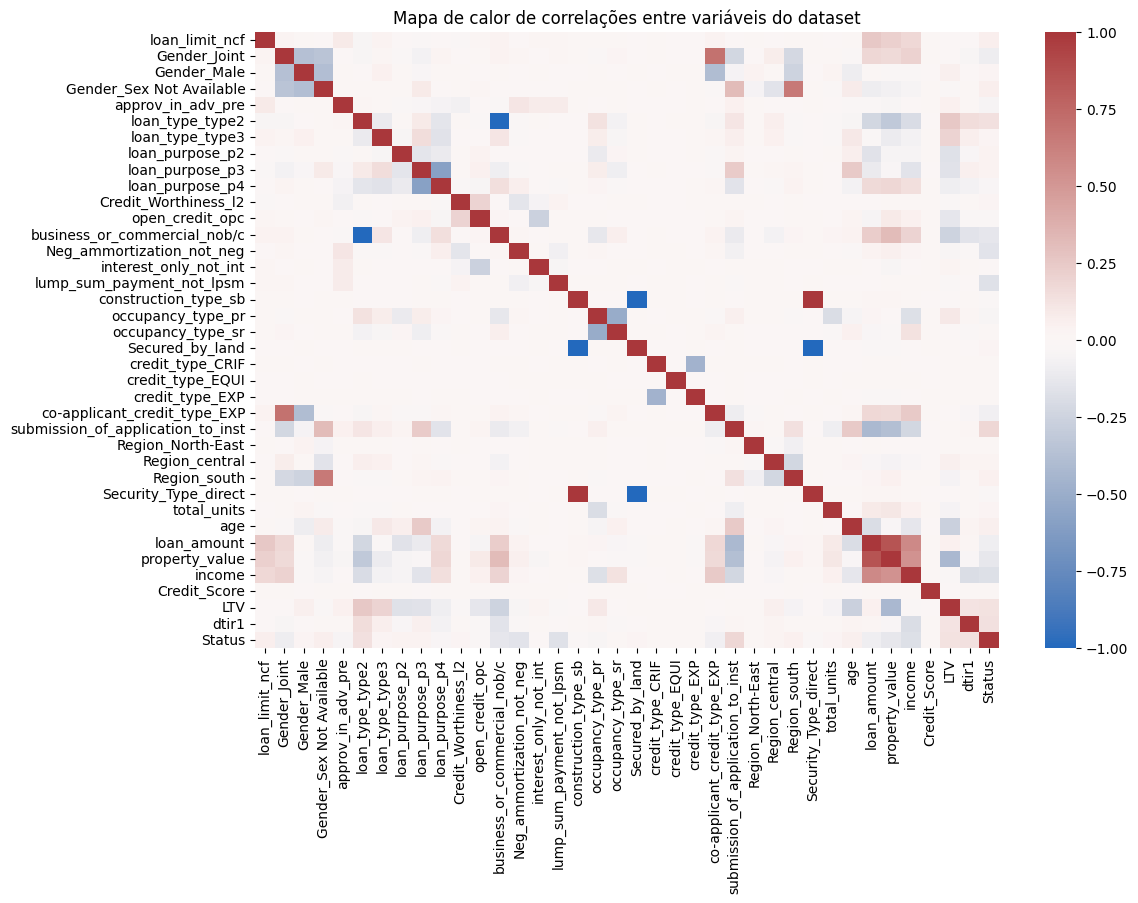

In [65]:
# Correlação e heatmap das features e target
plt.figure(figsize=(12,8))
sns.heatmap(treino.corr(), cmap='vlag')
plt.title('Mapa de calor de correlações entre variáveis do dataset')
plt.xticks(rotation=90)
plt.show()

## 3. Seleção de Features e Redução de Dimensionalidade

### 3.1 Testando feature selection com Lasso, Permutation Importance e RFE

- Lasso

In [29]:
estimador_lasso = Lasso(random_state=42)

estimador_lasso.fit(X_train_transformed, y_train_resampled)

estimador_lasso.coef_

array([ 0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0.,
       -0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
        0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0.])

- Permutation Importance

In [27]:
estimador = DecisionTreeClassifier().fit(X_train_transformed, y_train_resampled)

permutacao = permutation_importance(estimador, X_test_transformed, y_test, random_state=42)

In [28]:
dados = {
    'importancia': permutacao.importances_mean,
    'std': permutacao.importances_std
}

importancia = pd.DataFrame(dados, index=estimador.feature_names_in_).sort_values(by='importancia', ascending=False)#.head(10)
importancia

importancia       std
income                                0.075605  0.001572
LTV                                   0.059381  0.001329
dtir1                                 0.047047  0.002487
property_value                        0.039212  0.001236
loan_amount                           0.038101  0.000962
loan_purpose_p3                       0.025885  0.000930
submission_of_application_to_inst     0.022134  0.000751
business_or_commercial_nob/c          0.017405  0.000545
loan_type_type3                       0.014300  0.000375
lump_sum_payment_not_lpsm             0.010022  0.000662
Neg_ammortization_not_neg             0.009862  0.001189
approv_in_adv_pre                     0.008313  0.000529
occupancy_type_pr                     0.007140  0.000655
loan_purpose_p4                       0.005619  0.000899
Gender_Joint                          0.004813  0.000316
age                                   0.004556  0.000683
Credit_Worthiness_l2                  0.004007  0.000280
loan_limit_ncf                        0.002813  0.000567
Gender_Sex Not Available              0.001861  0.000408
Region_south                          0.001549  0.001110
co-applicant_credit_type_EXP          0.001417  0.000525
loan_type_type2                       0.001097  0.000117
Credit_Score                          0.000875  0.000734
credit_type_EXP                       0.000792  0.000381
Gender_Male                           0.000639  0.000498
interest_only_not_int                 0.000625  0.000258
loan_purpose_p2                       0.000563  0.000159
occupancy_type_sr                     0.000347  0.000098
total_units                           0.000285  0.000229
Region_central                        0.000118  0.000268
open_credit_opc                       0.000104  0.000000
Region_North-East                     0.000049  0.000078
Security_Type_direct                  0.000028  0.000026
Secured_by_land                       0.000000  0.000000
credit_type_EQUI                      0.000000  0.000000
construction_type_sb                  0.000000  0.000000
credit_type_CRIF                     -0.000493  0.000613

Adotaremos valor de corte para selecionar as Features, aquelas que tiveram importância superior ou igual a 0.01

- RFECV

In [70]:
# Tentei ajustar o valor de max_iter porque ao rodar aparecia o aviso.
# Cheguei a 600 e continua mostrando o aviso. Cuidar ao rodar ou mudar o max_iter,
# pq aumenta bastante tbm o tempo de processamento quanto maior o valor.
estimador_rfecv = LogisticRegression(max_iter=600)
rfecv = RFECV(estimador_rfecv, cv=5, verbose=1, n_jobs=-1)

rfecv.fit(X_train_transformed, y_train_resampled)

Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.


RFECV(cv=5, estimator=LogisticRegression(max_iter=600), n_jobs=-1, verbose=1)

In [71]:
# Mesmo mudando o max_iter, as features não mudaram
rfecv.n_features_

30

In [72]:
rfecv.support_

array([ True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True])

- Seguiremos com a feature selection através do método de permutation importance

In [30]:
# Rodar
X_train_ftselec = X_train_transformed.drop(columns=list(importancia[importancia['importancia'] < 0.01].index))

X_test_ftselec = X_test_transformed.drop(columns=list(importancia[importancia['importancia'] < 0.01].index))

print(X_train_ftselec.shape)
print(X_test_ftselec.shape)

(30974, 10)
(28797, 10)


### 3.2 Redução de dimensionalidade usando PCA

In [31]:
pca = PCA(random_state=42)
pca.fit(X_train_ftselec)

PCA(random_state=42)

In [32]:
pca.explained_variance_ratio_

array([0.42738039, 0.20508531, 0.17714933, 0.08099522, 0.04446539,
       0.02590021, 0.02024649, 0.00876986, 0.00656921, 0.0034386 ])

#### Visualização da variância

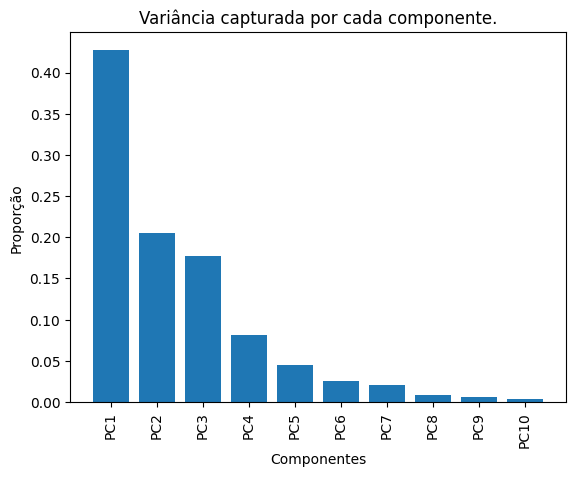

In [33]:
labels = [f'PC{i+1}' for i in range(pca.n_components_)]
plt.bar(labels, pca.explained_variance_ratio_)
plt.title("Variância capturada por cada componente.")
plt.xlabel('Componentes')
plt.ylabel('Proporção')
plt.xticks(rotation=90)
plt.show()

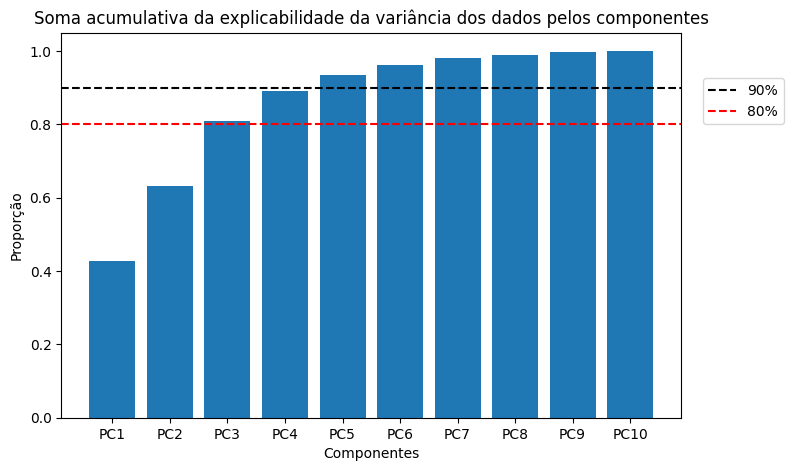

In [34]:
# Utilizando o modelo com os 10 componentes do PCA
plt.figure(figsize=(8,5))
labels = [f'PC{i+1}' for i in range(pca.n_components_)]
plt.bar(labels, pca.explained_variance_ratio_.cumsum())
plt.axhline(y=0.9, color='k', linestyle= '--', label="90%")
plt.axhline(y=0.8, color='r', linestyle= '--', label="80%")
plt.legend(bbox_to_anchor = (1.1, 0.9), loc = 'upper center')
plt.title("Soma acumulativa da explicabilidade da variância dos dados pelos componentes")
plt.xlabel('Componentes')
plt.ylabel('Proporção')
plt.show()

#### Transform do PCA

In [35]:
# Rodar
# Cria e fita o PCA
pca_final = PCA(n_components = 4, random_state=42)
pca_final.fit(X_train_ftselec)

# Transforma as features do dataset de treino nas features do PCA
X_train_pca = pca_final.transform(X_train_ftselec)

# Cria um dataframe, onde agora as features são o componentes do pca_final
labels_pca_final = [f"PC{i+1}" for i in range(pca_final.n_components_)]
X_train_pca = pd.DataFrame(X_train_pca, columns=labels_pca_final)

X_train_pca.shape

(30974, 4)

In [36]:
# Rodar
#Aplica o PCA nos dados de teste e cria o dataset
X_test_pca = pca_final.transform(X_test_ftselec)
X_test_pca = pd.DataFrame(X_test_pca, columns=labels_pca_final)

X_test_pca.shape

(28797, 4)

## 4. Machine Learning

### 4.1 Testes com Regressão Logística, Random Forest e Gradient Boosting

- Logistic Regression

In [37]:
# Modelo somente com Feature Selection
model_log = LogisticRegression()
model_log.fit(X_train_ftselec, y_train_resampled)
y_pred_logtest = model_log.predict(X_test_ftselec)
y_pred_logtrain = model_log.predict(X_train_ftselec)

print('Classification Report - Treino')
print(classification_report(y_train_resampled, y_pred_logtrain))

print('\nClassification Report - Teste')
print(classification_report(y_test, y_pred_logtest))

Classification Report - Treino
              precision    recall  f1-score   support

           0       0.64      0.64      0.64     15487
           1       0.64      0.64      0.64     15487

    accuracy                           0.64     30974
   macro avg       0.64      0.64      0.64     30974
weighted avg       0.64      0.64      0.64     30974


Classification Report - Teste
              precision    recall  f1-score   support

           0       0.83      0.63      0.72     21743
           1       0.35      0.60      0.44      7054

    accuracy                           0.62     28797
   macro avg       0.59      0.62      0.58     28797
weighted avg       0.71      0.62      0.65     28797



In [38]:
# Modelo com Feature Selection e PCA
model_log = LogisticRegression()
model_log.fit(X_train_pca, y_train_resampled)
y_pred_logtest = model_log.predict(X_test_pca)
y_pred_logtrain = model_log.predict(X_train_pca)

print('Classification Report - Treino')
print(classification_report(y_train_resampled, y_pred_logtrain))

print('\nClassification Report - Teste')
print(classification_report(y_test, y_pred_logtest))

Classification Report - Treino
              precision    recall  f1-score   support

           0       0.61      0.58      0.59     15487
           1       0.60      0.62      0.61     15487

    accuracy                           0.60     30974
   macro avg       0.60      0.60      0.60     30974
weighted avg       0.60      0.60      0.60     30974


Classification Report - Teste
              precision    recall  f1-score   support

           0       0.81      0.57      0.67     21743
           1       0.31      0.60      0.41      7054

    accuracy                           0.58     28797
   macro avg       0.56      0.58      0.54     28797
weighted avg       0.69      0.58      0.61     28797



- Random Forest

In [83]:
# Modelo somente com Feature Selection
model_rfc = RandomForestClassifier()

model_rfc.fit(X_train_ftselec, y_train_resampled)
y_pred_rfctrain = model_rfc.predict(X_train_ftselec)
y_pred_rfctest = model_rfc.predict(X_test_ftselec)

print('Classification Report - Treino')
print(classification_report(y_train_resampled, y_pred_rfctrain))

print('\nClassification Report - Teste')
print(classification_report(y_test, y_pred_rfctest))

Classification Report - Treino
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15487
           1       1.00      1.00      1.00     15487

    accuracy                           1.00     30974
   macro avg       1.00      1.00      1.00     30974
weighted avg       1.00      1.00      1.00     30974


Classification Report - Teste
              precision    recall  f1-score   support

           0       0.84      0.70      0.76     21743
           1       0.39      0.58      0.46      7054

    accuracy                           0.67     28797
   macro avg       0.61      0.64      0.61     28797
weighted avg       0.73      0.67      0.69     28797



In [40]:
# Modelo com Feature Selection e PCA
model_rfc = RandomForestClassifier()

model_rfc.fit(X_train_pca, y_train_resampled)
y_pred_rfctest = model_log.predict(X_test_pca)
y_pred_rfctrain = model_log.predict(X_train_pca)

print('Classification Report - Treino')
print(classification_report(y_train_resampled, y_pred_rfctrain))

print('\nClassification Report - Teste')
print(classification_report(y_test, y_pred_rfctest))

Classification Report - Treino
              precision    recall  f1-score   support

           0       0.61      0.58      0.59     15487
           1       0.60      0.62      0.61     15487

    accuracy                           0.60     30974
   macro avg       0.60      0.60      0.60     30974
weighted avg       0.60      0.60      0.60     30974


Classification Report - Teste
              precision    recall  f1-score   support

           0       0.81      0.57      0.67     21743
           1       0.31      0.60      0.41      7054

    accuracy                           0.58     28797
   macro avg       0.56      0.58      0.54     28797
weighted avg       0.69      0.58      0.61     28797



- XGBoost

In [39]:
# Modelo somente com Feature Selection
model_xgb = XGBClassifier()

model_xgb.fit(X_train_ftselec, y_train_resampled)
y_pred_xgbtrain = model_xgb.predict(X_train_ftselec)
y_pred_xgbtest = model_xgb.predict(X_test_ftselec)

print('Classification Report - Treino')
print(classification_report(y_train_resampled, y_pred_xgbtrain))

print('\nClassification Report - Teste')
print(classification_report(y_test, y_pred_xgbtest))

Classification Report - Treino
              precision    recall  f1-score   support

           0       0.74      0.84      0.79     15487
           1       0.82      0.70      0.75     15487

    accuracy                           0.77     30974
   macro avg       0.78      0.77      0.77     30974
weighted avg       0.78      0.77      0.77     30974


Classification Report - Teste
              precision    recall  f1-score   support

           0       0.84      0.76      0.80     21743
           1       0.43      0.57      0.49      7054

    accuracy                           0.71     28797
   macro avg       0.64      0.66      0.64     28797
weighted avg       0.74      0.71      0.72     28797



In [87]:
# Modelo com Feature Selection e PCA
model_xgb = XGBClassifier()

model_xgb.fit(X_train_pca, y_train_resampled)
y_pred_xgbtrain = model_xgb.predict(X_train_pca)
y_pred_xgbtest = model_xgb.predict(X_test_pca)

print('Classification Report - Treino')
print(classification_report(y_train_resampled, y_pred_xgbtrain))

print('\nClassification Report - Teste')
print(classification_report(y_test, y_pred_xgbtest))

Classification Report - Treino
              precision    recall  f1-score   support

           0       0.71      0.81      0.76     15487
           1       0.78      0.67      0.72     15487

    accuracy                           0.74     30974
   macro avg       0.74      0.74      0.74     30974
weighted avg       0.74      0.74      0.74     30974


Classification Report - Teste
              precision    recall  f1-score   support

           0       0.82      0.70      0.76     21743
           1       0.36      0.51      0.42      7054

    accuracy                           0.66     28797
   macro avg       0.59      0.61      0.59     28797
weighted avg       0.71      0.66      0.68     28797



### 4.2 Ajuste de Hiperparâmetros usando Otimização Bayesiana

- Otimização Bayesiana

In [41]:
# Rodar
def objetivo(parametros):
    learning_rate = parametros['learning_rate']
    max_depth = parametros['max_depth']
    n_estimators = parametros['n_estimators']
    
    model_xgb_est = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators
    )
    
    score = cross_val_score(model_xgb_est, X_train_ftselec, y_train_resampled, cv=5).mean()
    
    return -score

In [42]:
# Rodar
search_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'max_depth': hp.uniformint('max_depth', 2, 10),
    'n_estimators': hp.uniformint('n_estimators', 100, 1000)
}

In [43]:
# Rodar
tentativas = Trials()
best_trial = fmin(fn=objetivo, space=search_space, max_evals=100, trials=tentativas)

print(best_trial)

TPE is being used as the default algorithm.


100%|██████████| 100/100 [19:09<00:00, 11.50s/trial, best loss: -0.701684933973699]
{'learning_rate': 0.036703416126095366, 'max_depth': 4.0, 'n_estimators': 843.0}


In [61]:
# Imprimindo valores para guardar o resultado
print(f"Learning rate: {best_trial['learning_rate']}")
print(f"Max depth: {best_trial['max_depth']}")
print(f"Estimators: {best_trial['n_estimators']}")

Learning rate: 0.036703416126095366
Max depth: 4.0
Estimators: 843.0


### 4.3 Modelo final com XGBoost

In [62]:
# Rodar
model_xgb_final = XGBClassifier(
        learning_rate=best_trial['learning_rate'],
        max_depth=int(best_trial['max_depth']),
        n_estimators=int(best_trial['n_estimators'])
    )

model_xgb_final.fit(X_train_ftselec, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.036703416126095366,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=843, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [65]:
# Rodar
y_pred_finaltrain = model_xgb_final.predict(X_train_ftselec)
y_pred_finaltest = model_xgb_final.predict(X_test_ftselec)

print('Classification Report - Treino')
print(classification_report(y_train_resampled, y_pred_finaltrain))

print('\nClassification Report - Teste')
print(classification_report(y_test, y_pred_finaltest))

Classification Report - Treino
              precision    recall  f1-score   support

           0       0.70      0.79      0.75     15487
           1       0.76      0.67      0.71     15487

    accuracy                           0.73     30974
   macro avg       0.73      0.73      0.73     30974
weighted avg       0.73      0.73      0.73     30974


Classification Report - Teste
              precision    recall  f1-score   support

           0       0.84      0.76      0.80     21743
           1       0.43      0.57      0.49      7054

    accuracy                           0.71     28797
   macro avg       0.64      0.66      0.65     28797
weighted avg       0.74      0.71      0.72     28797



## 5. Explicabilidade do modelo

A explicabilidade, ou interpretabilidade do modelo nos ajuda a entender e explicar como o modelo funciona e como toma decisões. Ela é de extrema importância para garantir a transparência e compreensão dos resultados, além de ajudar a detectar possíveis vieses e problemas éticos que podem estar presentes no modelo.

### 5.1 Visualização usando Lime

In [66]:
# Criando o explicador
explicador = lime_tabular.LimeTabularExplainer(X_train_ftselec.values, mode='classification', 
                                               class_names=model_xgb_final.classes_, feature_names=model_xgb_final.feature_names_in_)

explicador

In [75]:
explicador_instancia = explicador.explain_instance(X_test_ftselec.iloc[1], model_xgb_final.predict_proba, num_features=model_xgb_final.n_features_in_)
explicador_instancia.show_in_notebook()

Pelo resultado apresentado pelo Lime, podemos observar que a escolha feita pelo modelo foi baseada principalmente em 5 features, sendo 'income' a mais importante.

In [67]:
# Conferindo os valores da linha usada no teste do Lime
X_test_ftselec.iloc[[1]]

loan_type_type3  loan_purpose_p3  business_or_commercial_nob/c   
67657              0.0              0.0                           1.0  \

       lump_sum_payment_not_lpsm  submission_of_application_to_inst   
67657                        1.0                                0.0  \

       loan_amount  property_value    income      LTV     dtir1  
67657    -0.148605       -0.171848  0.843258 -0.03203 -0.330217

### 5.2 Visualizações usando SHAP

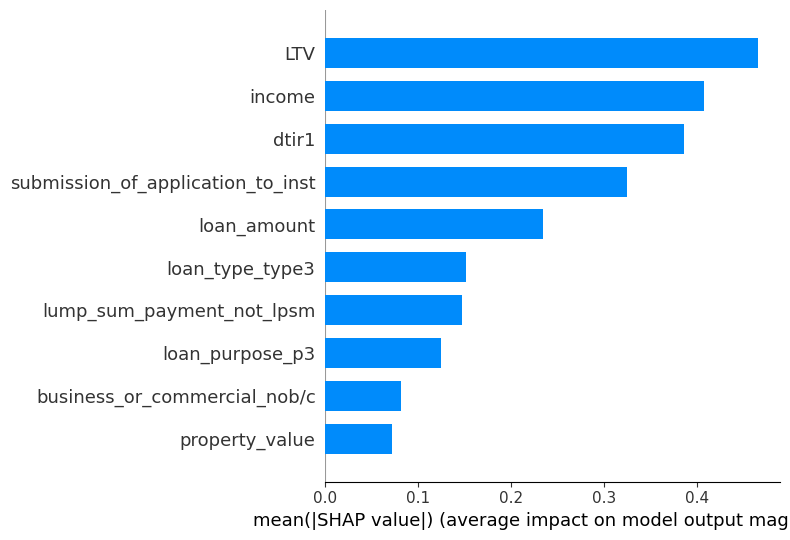

In [73]:
explicador_sh = shap.TreeExplainer(model_xgb_final)
shap_values = explicador_sh.shap_values(X_train_ftselec)

shap.summary_plot(shap_values=shap_values,  features=X_train_ftselec, plot_type='bar')

Vemos que as features 'LTV' (loan-to-value, ou relação empréstimo-valor) e 'income' (renda) são as que mais impactam no resultado final, seguidas por 'dtir1' (debt to income ratio, ou razão entre dívida e renda).

In [76]:
explicador_sh = shap.Explainer(model_xgb_final, X_train_ftselec)
shap_values = explicador_sh(X_train_ftselec)

100%|===================| 30914/30974 [06:20<00:00]        

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


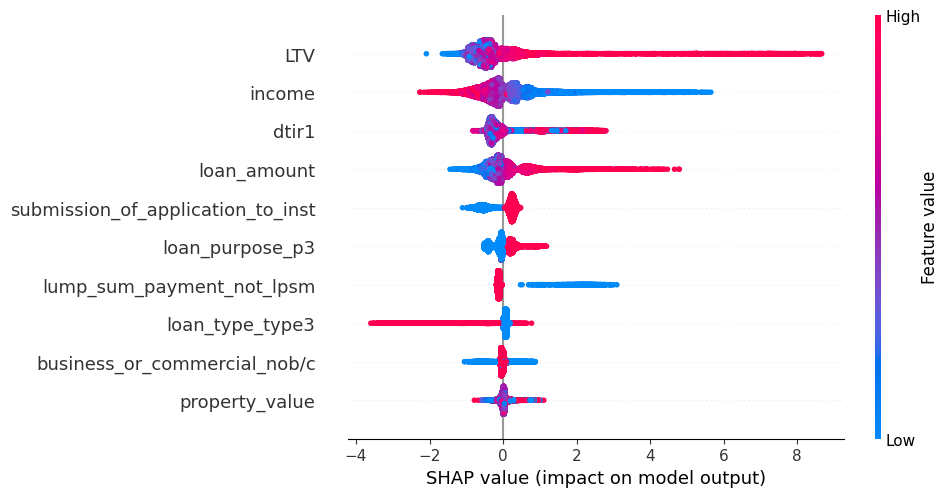

In [77]:
shap.plots.beeswarm(shap_values)

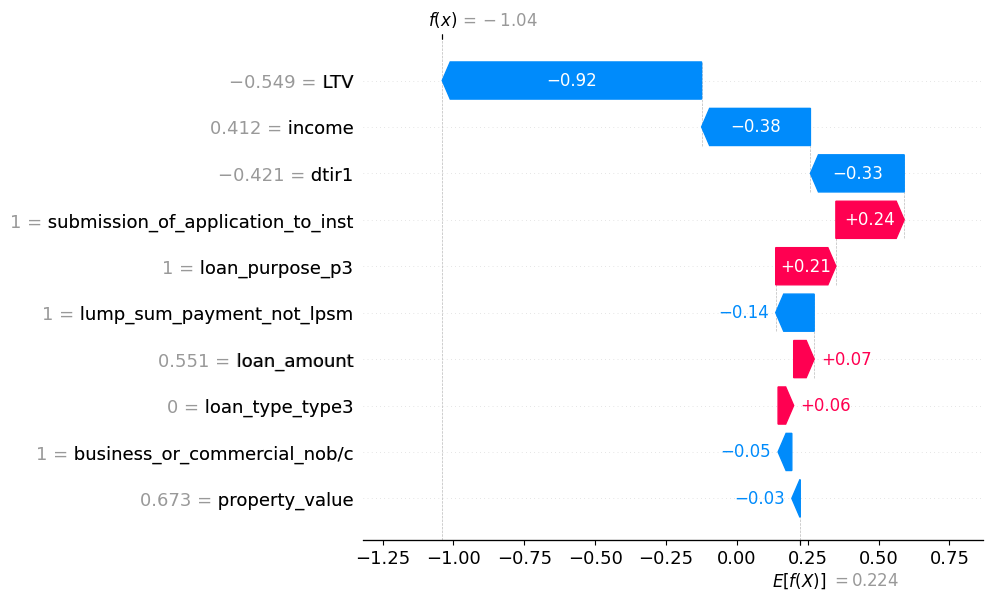

In [88]:
shap.plots.waterfall(shap_values[1])